**Test of the Gaussian Quadrature**  

References:
- sections 7.2 and 7.5 *in* **Judd, Kenneth L. (1998)**. Numerical Methods in Economics. MIT Press.  
- details of the implementation in `GH_Quadrature.pdf`.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import grsam

Instanciation

In [4]:
portf = grsam.Portfolio(horizon=50)
portf.standard_initialization()

print("Bivariate distribution")
print(f" mean vector: {portf.mean}")
print(f" covariance matrix: {portf.cov[0,:]}")
print(f"                    {portf.cov[1,:]}")
print("Prior over the mean vector")
print(f" mean vector: {portf.mean_belief_init}")
print(f" covariance matrix: {portf.cov_belief_init[0,:]}")
print(f"                    {portf.cov_belief_init[1,:]}")

Bivariate distribution
 mean vector: [0.08 0.08]
 covariance matrix: [0.04 0.02]
                    [0.02 0.04]
Prior over the mean vector
 mean vector: [0.13 0.13]
 covariance matrix: [0.004 0.   ]
                    [0.   0.01]


Initialize the quadrature nodes' positions and weights for `n_Gauss` nodes.

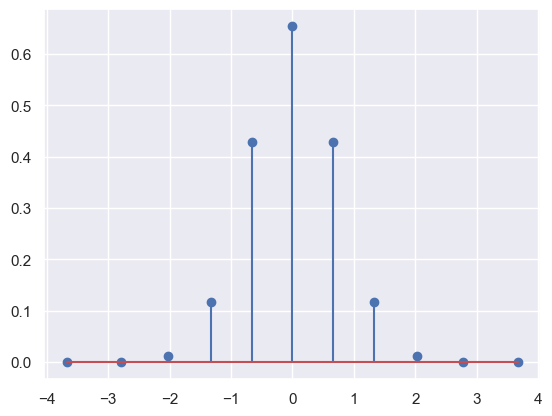

In [5]:
portf.init_GaussHermite(n_Gauss=11)
fig = plt.stem(portf.x_gauss, portf.w_gauss)

Compute the values of the nodes for the bivariate distribution

In [6]:
portf.init_corr_nodes(cov=portf.cov)
portf.init_corr_nodes_double(cov_outer=portf.cov_belief_init)

In [7]:
R1 = np.exp(portf.mean_belief_init[0] + portf.R1_s) - portf.rf
R2 = np.exp(portf.mean_belief_init[1] + portf.R2_s) - portf.rf
weights = portf.W_n1 * portf.W_n2

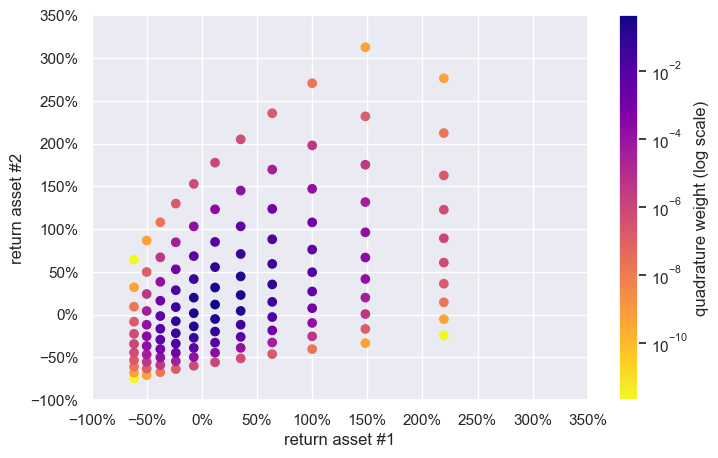

In [37]:
fig, ax = plt.subplots(figsize=(8,5))
paths = ax.scatter(R1.ravel(), R2.ravel(), c=weights, cmap='plasma_r', norm="log")
ax.set_xlabel("return asset #1")
ax.set_ylabel("return asset #2")
ax.set_xlim([-1, 3.5])
ax.set_ylim([-1, 3.5])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
fig.colorbar(paths, label="quadrature weight (log scale)")